# Machine Learning Foundation

## Course 3, Part b: K-Nearest Neighbor LAB


## Introduction and Learning Goals

In this lab, we will explore classification using the K-Nearest Neighbors approach. We will use a customer churn dataset from the telecom industry, which includes customer data such as long-distance usage, data usage, monthly revenue, types of offerings, and other services purchased by customers. The data, based on a fictional telecom firm, includes several Excel files which have been combined and are available in the course materials. We are using the subset of customers who have phone accounts. Since the data includes a mix of numeric, categorical, and ordinal variables, we will load this data and do some preprocessing. Then we will use K-nearest neighbors to predict customer churn rates.

After completing this lab, you should have a working understanding of how to preprocess a variety of variables to apply the K-Nearest Neighbors algorithm, understand how to choose K, and understand how to evaluate model performance.


In [2]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

## Question 1

* We begin by importing the data. Examine the columns and data.
* Notice that the data contains a unique ID, an indicator for phone customer status, total lifetime value, total revenue, and a bank-estimated churn score. We will not be using these features, so they can be dropped from the data.
* Begin by taking an initial look at the data, including both numeric and non-numeric features.


In [4]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/churndata_processed.csv")

In [5]:
df.head()

,months,multiple,gb_mon,security,backup,protection,support,unlimited,contract,paperless,...,payment_Credit Card,payment_Mailed Check,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E
0,0.00,0,0.094118,0,0,1,0,0,0.0,1,...,0,0,1,0,0,0,0,0,0,0
1,0.00,1,0.200000,0,1,0,0,1,0.0,1,...,1,0,0,1,0,0,0,0,0,1
2,0.25,1,0.611765,0,0,0,0,1,0.0,1,...,0,0,0,1,0,0,0,0,1,0
3,0.25,0,0.141176,0,1,1,0,1,0.0,1,...,0,0,0,1,0,0,0,1,0,0
4,0.50,1,0.164706,0,0,0,0,1,0.0,1,...,0,0,0,1,0,0,0,1,0,0


In [6]:
df.columns

Index(['months', 'multiple', 'gb_mon', 'security', 'backup', 'protection',
       'support', 'unlimited', 'contract', 'paperless', 'monthly',
       'satisfaction', 'churn_value', 'payment_Credit Card',
       'payment_Mailed Check', 'internet_type_DSL',
       'internet_type_Fiber Optic', 'internet_type_None', 'offer_Offer A',
       'offer_Offer B', 'offer_Offer C', 'offer_Offer D', 'offer_Offer E'],
      dtype='object')

In [7]:
df.dtypes

months                       float64
multiple                       int64
gb_mon                       float64
security                       int64
backup                         int64
protection                     int64
support                        int64
unlimited                      int64
contract                     float64
paperless                      int64
monthly                      float64
satisfaction                 float64
churn_value                    int64
payment_Credit Card            int64
payment_Mailed Check           int64
internet_type_DSL              int64
internet_type_Fiber Optic      int64
internet_type_None             int64
offer_Offer A                  int64
offer_Offer B                  int64
offer_Offer C                  int64
offer_Offer D                  int64
offer_Offer E                  int64
dtype: object

In [8]:
df.describe()

,months,multiple,gb_mon,security,backup,protection,support,unlimited,contract,paperless,...,payment_Credit Card,payment_Mailed Check,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.433551,0.421837,0.241358,0.286668,0.344881,0.343888,0.290217,0.673719,0.377396,0.592219,...,0.390317,0.054664,0.234559,0.430924,0.216669,0.073832,0.116996,0.058924,0.085475,0.114298
std,0.398231,0.493888,0.240223,0.452237,0.475363,0.475038,0.453895,0.468885,0.424234,0.491457,...,0.487856,0.227340,0.423753,0.495241,0.412004,0.261516,0.321438,0.235499,0.279607,0.318195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750000,1.000000,0.317647,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Question 2

* Identify which variables are binary, categorical and not ordinal, categorical and ordinal, and numeric.  The non-numeric features will need to be encoded using methods we have discussed in the course.
* Start by identifying the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables. 
* Note that the variable 'months' can be treated as numeric, but it may be more convenient to transform it to an ordinal variable.
* For the other categorical variables, examine their values to determine which may be encoded ordinally.


In [ ]:
df_uniques = pd.DataFrame([[col, len(df[col].unique())] for col in df.columns], columns=['Variable', 'Count']).set_index('Variable')
df_uniques

Based on the above value_counts df, the cutoff for categorical is between 3 and 5, and anything greater than 5 should be classified as ordinal.

In [21]:
BINARY_CUTOFF = 2
CATEGORICAL_CUTOFF = 5

In [13]:
binary_columns = [col for col in df.columns if len(df[col].unique()) == 2]
binary_columns

['multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value',
 'payment_Credit Card',
 'payment_Mailed Check',
 'internet_type_DSL',
 'internet_type_Fiber Optic',
 'internet_type_None',
 'offer_Offer A',
 'offer_Offer B',
 'offer_Offer C',
 'offer_Offer D',
 'offer_Offer E']

In [30]:
ordinal_columns = [col for col in df.columns if len(df[col].unique()) > 2 and len(df[col].unique()) <= 5]
ordinal_columns

['months', 'contract', 'satisfaction']

In [31]:
numerical_columns = [col for col in df.columns if col not in binary_columns and col not in categorial_columns]
numerical_columns

['gb_mon', 'monthly']

In [32]:
assert len(binary_columns) + len(ordinal_columns) + len(numerical_columns) == len(df.columns)

array([[<Axes: title={'center': 'gb_mon'}>,
        <Axes: title={'center': 'monthly'}>]], dtype=object)

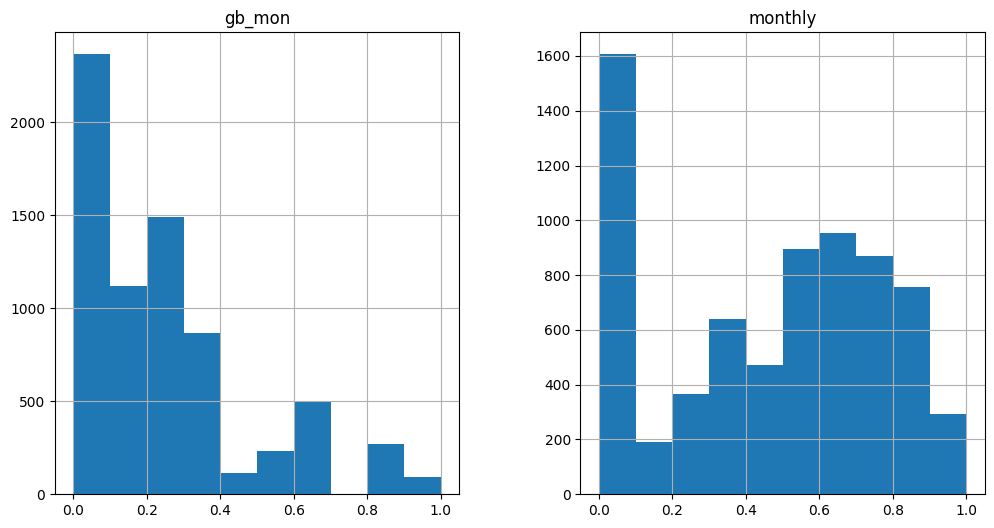

In [35]:
df[numerical_columns].hist(figsize=(12, 6))

## Question 3
* Having set up the variables, remember that the K-nearest neighbors algorithm uses distance and hence requires scaled data. 
* Scale the data using one of the scaling methods discussed in the course.
* Save the processed dataframe as a comma-separated file: 'churndata_processed.csv'


In [42]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [38]:
binary_transformer = Pipeline(
    steps=[
        ('encoder', LabelBinarizer())
    ]
)

In [39]:
ordinal_transformer = Pipeline(
    steps=[
        ('encoder', LabelEncoder())
    ]
)

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('bin', binary_transformer, binary_columns),
        ('ord', ordinal_transformer, ordinal_columns)
    ]
)